In [1]:
%matplotlib inline

In [2]:
# Import pandas and numpy
import pandas as pd
import numpy as np

# Import the statsmodels API
import statsmodels.api as sm

# Import the statsmodels formula API
import statsmodels.formula.api as smf

# Styling
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('phil.csv')

# We only care about years where we have a result.
df.loc[df['result'] == 'Saw Shadow', 'result'] = '6 more weeks of winter'
df.loc[df['result'] == 'No Shadow', 'result'] = 'Early spring'
df = df[(df['result'] == '6 more weeks of winter') | (df['result'] == 'Early spring')]

# Add the temperature data into the DataFrame
for i in ['feb', 'mar', 'apr', 'febmar', 'marapr', 'febmarapr']:
    temp = pd.read_csv('%s.csv' % i)
    temp['year'] = temp['Date'].astype(str).str.slice(0,4).astype(int)
    temp[i] = temp['Value']
    df = df.merge(temp[['year', i]], on='year')
    #temp.head()
    
# Create an offset for the year, so 1898 is 0, 1899 is 1 and so on
df['year_offset'] = df['year'] - df['year'].min() + 1

# Take out the effect of global warming and the baseline temperature, so we're just left with an offset from 0.
# Negative numbers mean it's colder than average, positive means it's warmer.
for i in ['feb', 'mar', 'apr', 'febmar', 'marapr', 'febmarapr']:
    mod = smf.ols(formula='%s ~ year_offset' % i, data = df).fit()
    
    df['%s_offset' % i] = df[i] - (mod.params[0] + df['year_offset']*mod.params[1])
    
    # Assign a class. 1 = 6 more weeks of winter, 2 = early spring
    df['%s_class' % i] = 1
    df.loc[df['%s_offset' % i] > 0, '%s_class' % i] = 2
    
df.head()

,year,result,feb,mar,apr,febmar,marapr,febmarapr,year_offset,feb_offset,...,mar_offset,mar_class,apr_offset,apr_class,febmar_offset,febmar_class,marapr_offset,marapr_class,febmarapr_offset,febmarapr_class
0,1898,6 more weeks of winter,35.37,41.05,50.79,38.21,45.92,42.40,1,3.080143,...,0.493508,2,0.348355,2,1.784411,2,0.419165,2,1.303244,2
1,1900,6 more weeks of winter,30.76,41.27,51.60,36.02,46.44,41.21,3,-1.584901,...,0.670658,2,1.132801,2,-0.454540,1,0.904950,2,0.072123,2
2,1901,6 more weeks of winter,29.86,40.71,49.39,35.29,45.05,39.99,4,-2.512423,...,0.089233,2,-1.089977,1,-1.209016,1,-0.502158,1,-1.168438,1
3,1902,Early spring,31.46,41.58,50.85,36.52,46.22,41.30,5,-0.939946,...,0.937808,2,0.357246,2,-0.003492,1,0.650734,2,0.121002,2
4,1903,6 more weeks of winter,28.42,42.21,50.22,35.32,46.22,40.28,6,-4.007468,...,1.546383,2,-0.285531,1,-1.227968,1,0.633627,2,-0.919559,1


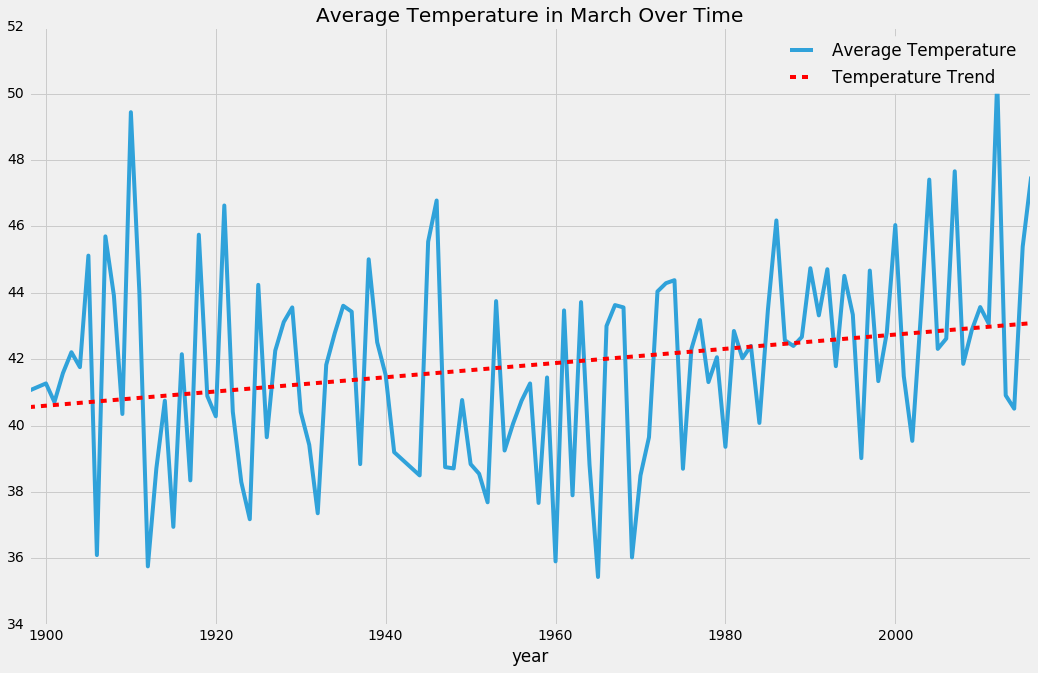

In [4]:
# Plot temperature trend

figure, ax = plt.subplots(figsize=(16,10))

df.plot('year', 'mar', title='Average Temperature in March Over Time', ax=ax, label='Average Temperature')

mod = smf.ols(formula='mar ~ year_offset', data = df).fit()
r = mod.params[0] + mod.params[1] * df['year_offset']
ax.plot(df['year'],r, 'r--', label='Temperature Trend')
ax.legend()

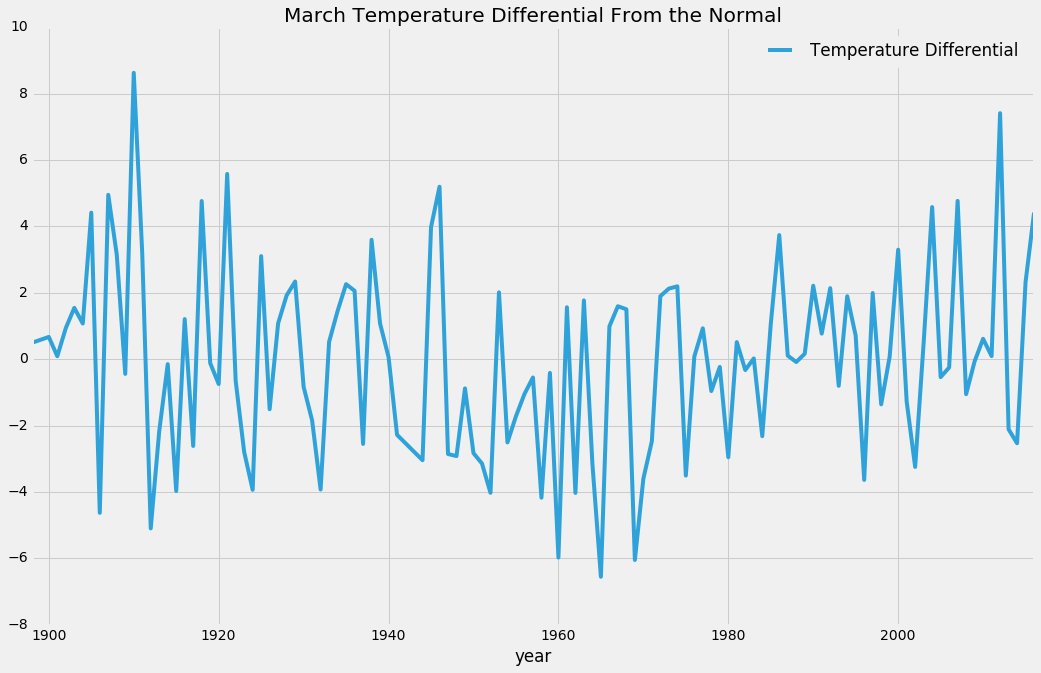

In [5]:
# Plot calculated offsets

figure, ax = plt.subplots(figsize=(16,10))

df.plot('year', 'mar_offset', title='March Temperature Differential From the Normal', ax=ax, label='Temperature Differential')

In [6]:
# Run OLS regression to see if Phil's predictions are ever statistically significant:

for i in ['feb', 'mar', 'apr', 'febmar', 'marapr', 'febmarapr']:
    # Run regression.  Note the call to `fit()` after the call to `ols`.
    mod = smf.ols(formula='%s_offset ~ C(result)' % i, data = df).fit()

    # Print the regression results if significant
    if mod.pvalues[1] <= .05:
        print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:             apr_offset   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6.339
Date:                Mon, 16 Jan 2017   Prob (F-statistic):             0.0132
Time:                        16:45:12   Log-Likelihood:                -228.05
No. Observations:                 116   AIC:                             460.1
Df Residuals:                     114   BIC:                             465.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept             

In [7]:
# Load the predictions for the rest of the groudhogs and clean the data

d = pd.read_csv('hogs.csv', sep='\t')
d['result'] = d['result'].str.extract('(.*)\[.*\]')
d['year'] = d['year'].astype(int)
d['name'] = d['name'].str.strip().str.replace(' ', '_')
d['name'] = d['name'].str.strip().str.replace('-', '_')
d = d[(d['result'] == '6 more weeks of winter') | (d['result'] == 'Early spring')]
names = d['name'].unique()
d.head()

c:\Users\Jeremy\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,year,result,name,location
0,2016,Early spring,Balzac_Billy,"Balzac, Alberta"
1,2016,6 more weeks of winter,Buckeye_Chuck,"Marion, Ohio"
2,2016,Early spring,Chattanooga_Chuck,"Chattanooga, Tennessee"
3,2016,6 more weeks of winter,Chesapeake_Chuck,"Newport News, Virginia"
4,2016,Early spring,Chuckles,"Manchester, Connecticut"


In [8]:
# Convert it into a DataFrame having dummy variables for each of the differnt groudhogs

all_hogs = pd.get_dummies(d, columns=['name'], prefix='', prefix_sep='')

# Indicate early spring predictions with a 2.  6 more weeks of winter will be a 1.  0 means no prediction for that year
all_hogs.loc[all_hogs['result'] == 'Early spring', names] *= 2
all_hogs = all_hogs.groupby('year', as_index=False).sum()
all_hogs = df.merge(all_hogs, on='year')

all_hogs

,year,result,feb,mar,apr,febmar,marapr,febmarapr,year_offset,feb_offset,...,Susquehanna_Sherman,T_Boy_the_Nutria,Tumbleweed,Uni,Western_Maryland_Murray,Wiarton_Willie,Winnipeg_Willow,Woodstock_Willie,Woody,Wynter_the_Groundhog
0,2008,6 more weeks of winter,34.70,41.86,50.40,38.28,46.13,42.32,111,-0.617303,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,2009,6 more weeks of winter,36.77,42.87,50.92,39.82,46.90,43.52,112,1.425175,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2010,6 more weeks of winter,31.80,43.57,53.24,37.69,48.41,42.87,113,-3.572347,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0
3,2011,Early spring,33.04,43.07,51.96,38.06,47.52,42.69,114,-2.359869,...,2.0,2.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0
4,2012,6 more weeks of winter,37.51,50.41,54.68,43.96,52.55,47.53,115,2.082608,...,2.0,2.0,0.0,1.0,1.0,2.0,0.0,2.0,2.0,2.0
5,2013,Early spring,34.77,40.91,49.68,37.84,45.30,41.79,116,-0.684914,...,1.0,2.0,0.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0
6,2014,6 more weeks of winter,32.13,40.51,51.69,36.32,46.10,41.44,117,-3.352436,...,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
7,2015,6 more weeks of winter,32.99,45.39,53.24,39.19,49.32,43.87,118,-2.519958,...,2.0,2.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0
8,2016,Early spring,39.47,47.50,53.20,43.49,50.35,46.72,119,3.932519,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0


In [9]:
# Run OLS on all the differnt groudhogs individually

for hog in d.dropna()['name'].unique():
    for i in ['feb', 'mar', 'apr', 'febmar', 'marapr', 'febmarapr']:
        mod = smf.ols(formula='%s_offset ~ C(%s)' % (i, hog), data = all_hogs[all_hogs[hog] > 0]).fit()

        # Print the regression results
        if len(mod.pvalues) > 1 and mod.pvalues[1] <= .05:
            print(mod.summary())

c:\Users\Jeremy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:             feb_offset   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     7.328
Date:                Mon, 16 Jan 2017   Prob (F-statistic):             0.0303
Time:                        16:45:27   Log-Likelihood:                -17.696
No. Observations:                   9   AIC:                             39.39
Df Residuals:                       7   BIC:                             39.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

c:\Users\Jeremy\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n))


                            OLS Regression Results                            
Dep. Variable:             mar_offset   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     13.69
Date:                Mon, 16 Jan 2017   Prob (F-statistic):             0.0208
Time:                        16:45:27   Log-Likelihood:                -11.644
No. Observations:                   6   AIC:                             27.29
Df Residuals:                       4   BIC:                             26.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

c:\Users\Jeremy\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


                            OLS Regression Results                            
Dep. Variable:             feb_offset   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     11.91
Date:                Mon, 16 Jan 2017   Prob (F-statistic):             0.0409
Time:                        16:45:27   Log-Likelihood:                -6.3742
No. Observations:                   5   AIC:                             16.75
Df Residuals:                       3   BIC:                             15.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -2

In [10]:
# Try a machine learning algorithm using all the predictions together.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

for m in ['feb', 'mar', 'apr', 'febmar', 'marapr', 'febmarapr']:
    results = []

    for i in range(200):
        train_x, test_x, train_y, test_y = train_test_split(all_hogs[names], all_hogs['%s_class' % m], test_size=0.2)

        rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
        rf.fit(train_x, train_y)
        results.append(rf.score(test_x, test_y))

    print(m)
    print('*'*20)
    print('prediction score:', np.array(results).mean())
    print('naive score:', max((all_hogs['%s_class' % m] == 1).sum() / 9, 1 - (all_hogs['%s_class' % m] == 1).sum() / 9))
    print('*'*20)

feb
********************
prediction score: 0.5675
naive score: 0.666666666667
********************
mar
********************
prediction score: 0.5975
naive score: 0.555555555556
********************
apr
********************
prediction score: 0.575
naive score: 0.555555555556
********************
febmar
********************
prediction score: 0.565
naive score: 0.666666666667
********************
marapr
********************
prediction score: 0.615
naive score: 0.555555555556
********************
febmarapr
********************
prediction score: 0.46
naive score: 0.555555555556
********************


In [100]:
# Try a machine learning algorithm using all the predictions together.

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.linear_model import SGDClassifier

for m in ['feb', 'mar', 'apr', 'febmar', 'marapr', 'febmarapr']:
    results = []

    for i in range(500):
        train_x, test_x, train_y, test_y = train_test_split(all_hogs[names], all_hogs['%s_class' % m], test_size=0.1)

        #rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
        rf = SVC(kernel='poly', degree=3)
        #rf = MLPClassifier(hidden_layer_sizes=(5,5), activation='tanh')
        #rf = SGDClassifier(loss='perceptron', penalty='l2', n_iter=5)
        rf.fit(train_x, train_y)
        results.append(rf.score(test_x, test_y))

    print(m)
    print('*'*20)
    print('prediction score:', np.array(results).mean())
    print('naive score:', max((all_hogs['%s_class' % m] == 1).sum() / 9, 1 - (all_hogs['%s_class' % m] == 1).sum() / 9))
    print('*'*20)

feb
********************
prediction score: 0.654
naive score: 0.666666666667
********************
mar
********************
prediction score: 0.73
naive score: 0.555555555556
********************
apr
********************
prediction score: 0.808
naive score: 0.555555555556
********************
febmar
********************
prediction score: 0.664
naive score: 0.666666666667
********************
marapr
********************
prediction score: 0.746
naive score: 0.555555555556
********************
febmarapr
********************
prediction score: 0.64
naive score: 0.555555555556
********************


In [79]:
rf.coef_

array([[ -9.62463908e+00,  -2.88739172e+01,   3.84985563e+01,
          3.84985563e+01,   1.02478180e-14,   1.70796967e-14,
          9.62463908e+00,   3.84985563e+01,  -1.92492782e+01,
         -9.62463908e+00,   5.12390900e-15,  -4.81231954e+01,
          1.92492782e+01,   3.84985563e+01,  -2.88739172e+01,
          9.62463908e+00,   9.62463908e+00,   1.92492782e+01,
          1.36637573e-14,   9.62463908e+00,   2.88739172e+01,
          3.84985563e+01,   1.92492782e+01,   3.84985563e+01,
          2.88739172e+01,   2.88739172e+01,   2.88739172e+01,
          1.92492782e+01,   6.83187866e-15,   4.81231954e+01,
         -9.62463908e+00,  -9.62463908e+00,  -2.88739172e+01,
          6.83187866e-15,   0.00000000e+00,   8.53984833e-15,
         -9.62463908e+00,  -9.62463908e+00,  -1.92492782e+01,
          9.62463908e+00,  -2.88739172e+01,   1.92492782e+01,
         -9.62463908e+00,   1.92492782e+01,   1.92492782e+01,
          1.92492782e+01,  -3.84985563e+01,  -1.92492782e+01]])

In [62]:
rf.predict(all_hogs[names])

array([ 1.375,  1.375,  1.375,  1.375,  1.375,  1.375,  1.375,  1.375,
        1.375])

In [27]:
rf.decision_function(all_hogs[names])

array([-0.99990201, -0.70416451, -1.00008659, -0.02846668,  1.000098  ,
       -0.528406  , -1.00001653,  1.00023357,  0.99967354])

In [29]:
all_hogs['febmarapr_class']

0    1
1    2
2    1
3    1
4    2
5    1
6    1
7    2
8    2
Name: febmarapr_class, dtype: int64

In [30]:
rf.predict(all_hogs[names])

array([1, 1, 1, 1, 2, 1, 1, 2, 2], dtype=int64)

In [99]:
from sklearn.feature_selection import SelectFromModel
#sfm = SelectFromModel(SGDClassifier(loss='perceptron', penalty='l2', n_iter=5), threshold='2*mean')
sfm = SelectFromModel(SVC(kernel='linear', degree=3), threshold='2*mean')
sfm.fit(all_hogs[names], all_hogs['marapr_class'])
names[sfm.get_support()]

array(['Balzac_Billy', 'Chuckles', 'French_Creek_Freddie',
       'General_Beauregard_Lee', 'Grady_the_Groundhog', 'Malverne_Mel',
       'Woodstock_Willie', 'Sir_Walter_Wally', 'Uni', 'Gus',
       'Octoraro_Orphie'], dtype=object)

In [81]:
names[sfm.get_support()]

array(['Balzac_Billy', 'Buckeye_Chuck', 'Chattanooga_Chuck',
       'Chesapeake_Chuck', 'Chuckles', 'Dunkirk_Dave',
       'French_Creek_Freddie', 'General_Beauregard_Lee',
       'Grady_the_Groundhog', 'Malverne_Mel', 'Nibbles', 'Stormy_Marmot',
       'T_Boy_the_Nutria', 'Woodstock_Willie', 'Cocalico_Cal',
       'Lawrenceville_Lucy', 'Sir_Walter_Wally', 'Uni', 'Winnipeg_Willow',
       'Potomac_Phil'], dtype=object)